In [1]:
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
block_path = '/home/AD/tsheehan/data/Pen01_Lft_AP750_ML1750__Site01_Z1100__B952_cat_P01_S01_1'
from ephys import core
from ephys import clust
from ephys import events
from ephys import rasters
import os
import scipy as sp
import scipy.io.wavfile as wf
import scipy.signal as signal
#import pywt # wavelet toolbox

In [2]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
# want to get STA and STC for example dataset
# load response (neurons), stimulus (wav files to spectrograms)
clusters = core.load_clusters(block_path) # pandas - DataFrame
neurons = (
    clusters[clusters.quality.isin(['Good'])]
    .sort_values(['quality','cluster'],ascending=False)
    .reset_index()
)
trials = events.load_trials(block_path)
stim_labels = list(set(trials.stimulus))
spikes = core.load_spikes(block_path)


In [10]:
fs = 44100
stim_labels[0]
stim_loc = block_path + '/stims'
files = os.listdir(stim_loc)
songs = []
spects = []
freqs = []
times = []
noverlap = 512
nperseg = 1024

for i in range(len(stim_labels)):
    this_label = stim_labels[i] +'.wav'
    my_song = [x for x in files if x in this_label]
    if my_song:
        this_song = wf.read(stim_loc + '/' + my_song[0])
        songs.append((this_song[1]))    
    
    my_spect = signal.spectrogram(songs[i],fs =fs, nperseg = nperseg,noverlap = noverlap)
    spects.append(my_spect[2])
    freqs.append(my_spect[0])
    times.append(my_spect[1])
    
    print(len(this_song[1]))

2892045
2961304
2674358
2400000
2400000


In [13]:
import get_STA
reload(get_STA)
stim_use = 2
neuron_ind = 12
this_label = stim_labels[stim_use]
these_trials = trials[trials['stimulus']==this_label]
this_st = these_trials['time_samples'].values
this_end = these_trials['stimulus_end'].values
dd = this_end-this_st

my_cluster = neurons['cluster'][neuron_ind]
my_spikes = spikes[spikes['cluster']==my_cluster]
my_times = my_spikes['time_samples']

#get_STA_p.get_STA_from_points(my_times,this_end,dd[0],songs[stim_use],50)
#tmp  = get_STA_p.get_STA_mult_song(my_times,songs,trials)
#get_STA_p.plot_STA_mult_song(my_times,songs,trials,[],1)

#get_STA_p.plot_STA_mult_neuron(neurons,spikes,songs,trials,40)
s_view = 2
c_lim = (-60,60)
#get_STA_p.visualize_reduced_spectrogram(songs[s_view],c_lim)
#get_STA_p.visualize_full_spectrogram(songs[s_view],c_lim)
ratio = get_STA.get_ds_rate(songs)
spk_times = my_spikes['time_samples'].values


(2892045, 3227, 896)
(2961304, 3304, 896)
(2674358, 2984, 896)
(2400000, 2678, 896)
(2400000, 2678, 896)


/home/AD/tsheehan/anaconda3/envs/mne/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


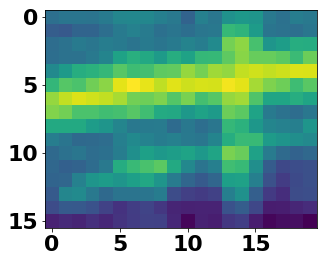

In [14]:
 
song_names = list(set(trials['stimulus']))
song_mask, song_ramp = get_STA.get_song_mask(trials,ratio/2)


STA,f = get_STA.get_sta(spk_times,songs,song_mask,song_ramp,20)
mSTA = np.mean(STA,0)
plt.imshow(mSTA)

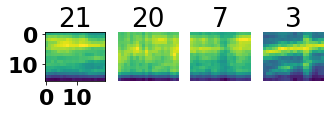

In [27]:
get_STA.visualize_some_stas(neurons,spikes,songs,song_mask,song_ramp,20)


In [68]:
# TODO 